
# **Imports:**

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
# import tensorflow_datasets as tfds
# from tensorflow.keras import layers
# from google.colab import files
# import os
# import copy
# import cv2
# import random
# from sklearn import model_selection
# from sklearn import preprocessing
# import keras
# from keras import layers
# import tensorflow as tf
# from tensorflow import keras
# import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image
# import cv2
# import os
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input, LSTM
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
# import os
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
import requests
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt


# **Methods:**

In [ ]:
def url_generator(stock_index: str, interval: str, yyyy_mm_dd: str) -> str:
  return f"https://stooq.pl/q/a2/d/?s={stock_index}&i={interval}&f={yyyy_mm_dd}"

def parse_stock_data(txt_data: str) -> list:
  lista = txt_data.split()
  ret = []
  for x in lista:
    a = x.split(',')
    ret.append({"Date":a[0], "Time":a[1], "Open":float(a[2]), "High":float(a[3]), "Low":float(a[4]), "Close":float(a[5])})
  return ret

In [ ]:
def calc_arithmetic_mean(tmp_data):
  sum = 0
  for a in tmp_data:
    sum += a
  return sum / len(tmp_data)

def format_number(liczba):
  return f"{liczba:.2f}"


In [ ]:
def get_prediction(tmp_y_data, tmp_batch_size):
  init_mean = calc_arithmetic_mean(tmp_y_data[:tmp_batch_size])
  list_of_predictions = [init_mean for i in range(0,tmp_batch_size)]

  for i in range(0, len(tmp_y_data)-tmp_batch_size):
    tmp = tmp_y_data[i:i+tmp_batch_size]
    list_of_predictions.append(calc_arithmetic_mean(tmp))
  return list_of_predictions

In [ ]:
def get_operations(stooq_vals, predictions):
  operations = []
  money = 0
  number_of_stock = 0

  for i in range(len(stooq_vals)):
    stock_last_val =  stooq_vals[i]
    predicted_val = predictions[i]
    nm_of_pos_stocks = int(size_of_single_operation / stock_last_val)


    buy_sell_multiplier = 1                                             # buy
    if stock_last_val > predicted_val:                                  # sell
      buy_sell_multiplier = -1

    money +=           nm_of_pos_stocks * stock_last_val * buy_sell_multiplier
    number_of_stock += nm_of_pos_stocks * buy_sell_multiplier
    operation = predicted_val * buy_sell_multiplier

    operations.append([operation, money+(number_of_stock*stock_last_val)])
  return operations


# **Parameters:**

In [ ]:
batch_size = 20
size_of_single_operation = 500     # robie operacje za 500
percent_of_train_data = 0.8
size_of_test_data = 100


# **Data:**

In [ ]:
now = datetime.datetime.now()
stock_index = "usdpln"
yyyy_mm_dd = f"{now.year:04d}{now.month:02d}{now.day:02d}"
url = url_generator(stock_index, "d", yyyy_mm_dd)
print(url)
resp = requests.get(url)
row_list = parse_stock_data(resp.text)

stooq_vals = [x["Close"] for x in row_list]

https://stooq.pl/q/a2/d/?s=usdpln&i=d&f=20240325


In [ ]:
tmp_train_y_data = stooq_vals[:int(len(stooq_vals)*percent_of_train_data)]
test_y_data = stooq_vals[int(len(stooq_vals)*percent_of_train_data):]

list_of_train_data = []
len_of_list_of_train_data = int(len(tmp_train_y_data) / size_of_test_data)

for i in range(len_of_list_of_train_data):
  list_of_train_data.append(tmp_train_y_data[i*size_of_test_data:(i+1)*size_of_test_data])

for i in range(len_of_list_of_train_data-1):
  i+= 0.5
  list_of_train_data.append(tmp_train_y_data[int(i*size_of_test_data):int((i+1)*size_of_test_data)])

# print(len(list_of_train_data))
# for a in list_of_train_data:
#   print(len(a))

# **Optymalizacja:**

In [ ]:
list_of_batch_size = []

for train_data in list_of_train_data:
  max_val = [1, 1]
  for batch_size in range(1,len(train_data)):
    list_of_predictions  = get_prediction(train_data, batch_size)     # pobierz liste intow - predykcje dla chunkow
    list_of_predictions = list_of_predictions[batch_size:]            # odciecie stalej poza srednia
    tmp_train_data = train_data[batch_size:]                              # odciecie stalej poza srednia

    # pobranie wyniku
    operations_b = get_operations(tmp_train_data, list_of_predictions)    # [operation, money]
    money = [a[1] for a in operations_b]
    money = money[-1]

    if money > max_val[0]:                                            # zapisanie najlepszego batch_size
      max_val[0] = money
      max_val[1] = batch_size

  list_of_batch_size.append(max_val[1])

print(f"list_of_batch_size    :   {list_of_batch_size}")


list_of_batch_size    :   [1, 18, 1, 16, 16, 46, 1, 18, 10, 34, 50]


# **Wyniki:**

In [ ]:
# test_y_data
test_y_data = stooq_vals[int(len(stooq_vals)*percent_of_train_data):]

list_of_list_of_predictions = []
for batch_size in list_of_batch_size:
  list_of_predictions  = get_prediction(test_y_data, batch_size)     # pobierz liste intow - predykcje dla chunkow
  list_of_list_of_predictions.append(list_of_predictions)

max_batch_size = max(list_of_batch_size)
test_y_data_cropped_batch = test_y_data[max_batch_size:]
list_of_list_of_predictions = [x[max_batch_size:] for x in list_of_list_of_predictions]

mean_list_of_predictions = []
for i in range(len(list_of_list_of_predictions[0])):
  tmp_list_of_prediciotns = [x[i] for x in list_of_list_of_predictions]
  mean = calc_arithmetic_mean(tmp_list_of_prediciotns)
  mean_list_of_predictions.append(mean)


In [ ]:
print(max_batch_size)
print(len(test_y_data))
print(len(test_y_data_cropped_batch))
print(len(mean_list_of_predictions))

50
150
100
100


In [ ]:
# pobranie wyniku
operations_b = get_operations(test_y_data_cropped_batch, mean_list_of_predictions)    # [operation, money]
operations = [a[0] for a in operations_b]
money      = [a[1] for a in operations_b]

money_end = money[-1]
print(f"money_end: {money_end}")

money_end: 33928.75139


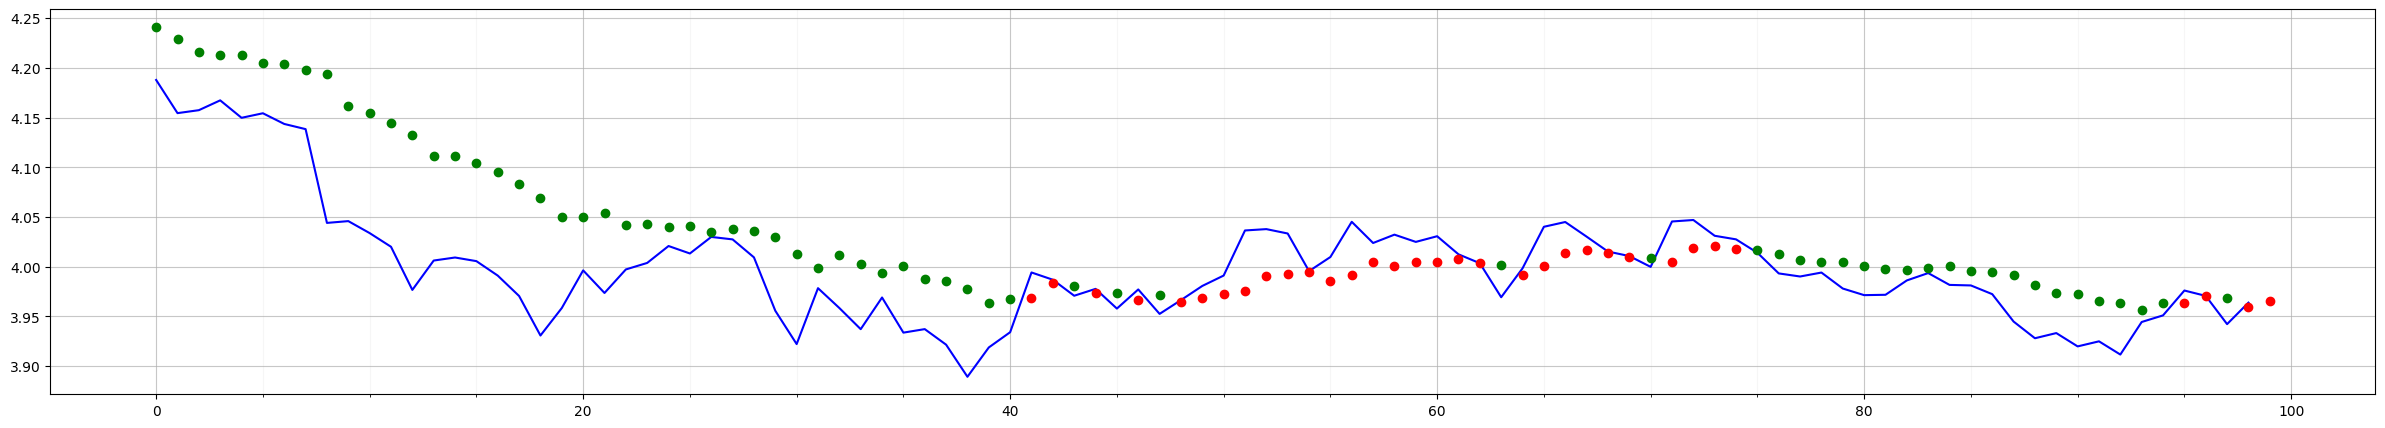

In [ ]:
plt.rcParams["figure.figsize"] = (30,5)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, len(stooq_vals)+1, 20)
minor_ticks = np.arange(0, len(stooq_vals)+1, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

limit = -1

plt.plot(test_y_data_cropped_batch[:limit], c="b")
for i, operation in enumerate(operations):
  if operation > 0:
    plt.plot(i, operation, "go")
  if operation < 0:
    plt.plot(i, -operation, "ro")

# **Test dla całości:**

[1, 18, 1, 16, 16, 46, 1, 18, 10, 34, 50]
50
750
700
700
money_end: 16109.09
money_max: 22731.90
money_min: -123323.67


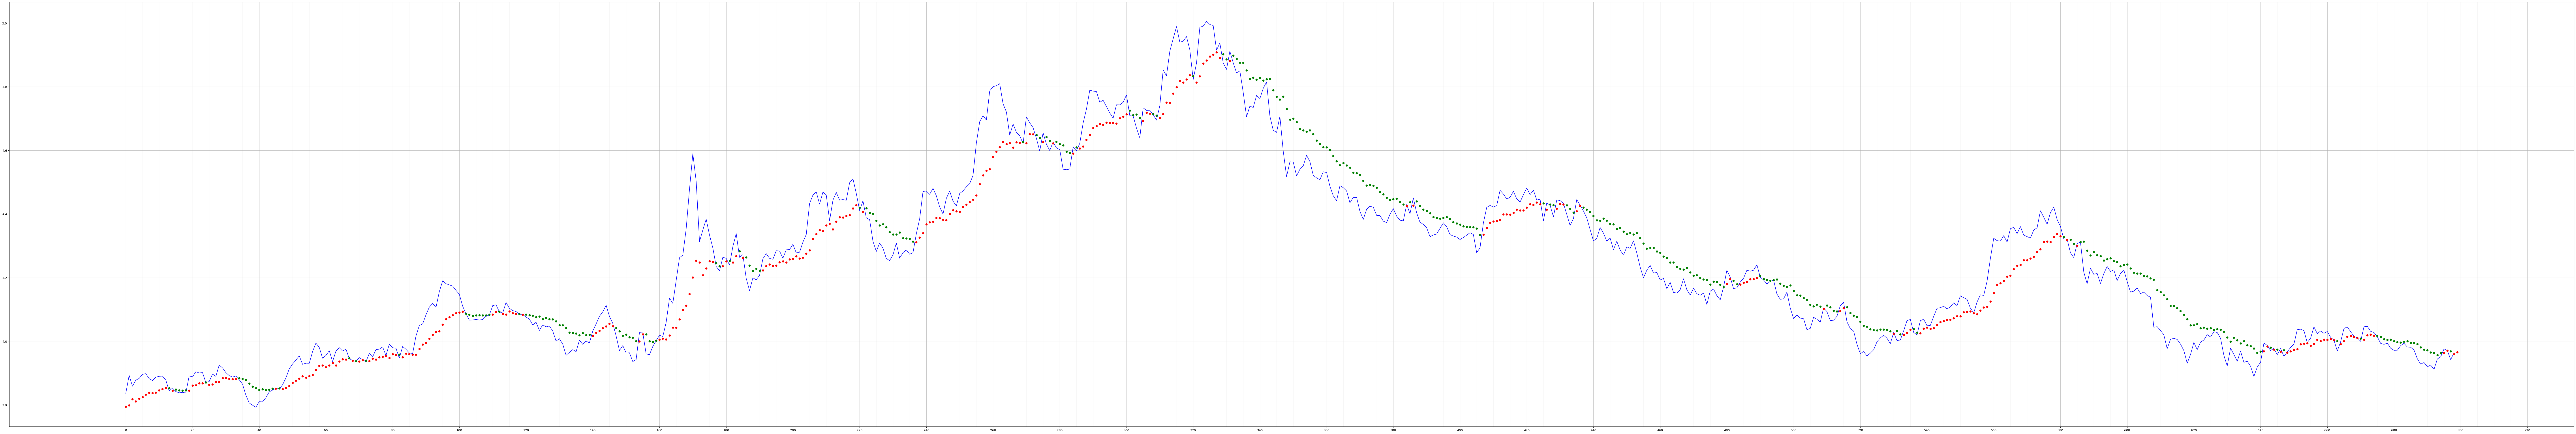

In [ ]:
# test_y_data
test_y_data = stooq_vals #[int(len(stooq_vals)*percent_of_train_data):]
print(list_of_batch_size)

list_of_list_of_predictions = []
for batch_size in list_of_batch_size:
  list_of_predictions  = get_prediction(test_y_data, batch_size)     # pobierz liste intow - predykcje dla chunkow
  list_of_list_of_predictions.append(list_of_predictions)

max_batch_size = max(list_of_batch_size)
test_y_data_cropped_batch = test_y_data[max_batch_size:]
list_of_list_of_predictions = [x[max_batch_size:] for x in list_of_list_of_predictions]

mean_list_of_predictions = []
for i in range(len(list_of_list_of_predictions[0])):
  tmp_list_of_prediciotns = [x[i] for x in list_of_list_of_predictions]
  mean = calc_arithmetic_mean(tmp_list_of_prediciotns)
  mean_list_of_predictions.append(mean)

print(max_batch_size)
print(len(test_y_data))
print(len(test_y_data_cropped_batch))
print(len(mean_list_of_predictions))

# pobranie wyniku
operations_b = get_operations(test_y_data_cropped_batch, mean_list_of_predictions)    # [operation, money]
operations = [a[0] for a in operations_b]
money      = [a[1] for a in operations_b]

money_end = money[-1]
print(f"money_end: {format_number(money_end)}")
print(f"money_max: {format_number(max(money))}")
print(f"money_min: {format_number(min(money))}")

plt.rcParams["figure.figsize"] = (150,25)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, len(stooq_vals)+1, 20)
minor_ticks = np.arange(0, len(stooq_vals)+1, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

limit = -1

plt.plot(test_y_data_cropped_batch[:limit], c="b")
for i, operation in enumerate(operations):
  if operation > 0:                                     # buy
    plt.plot(i, operation, "go")
  if operation < 0:                                     # sell
    plt.plot(i, -operation, "ro")

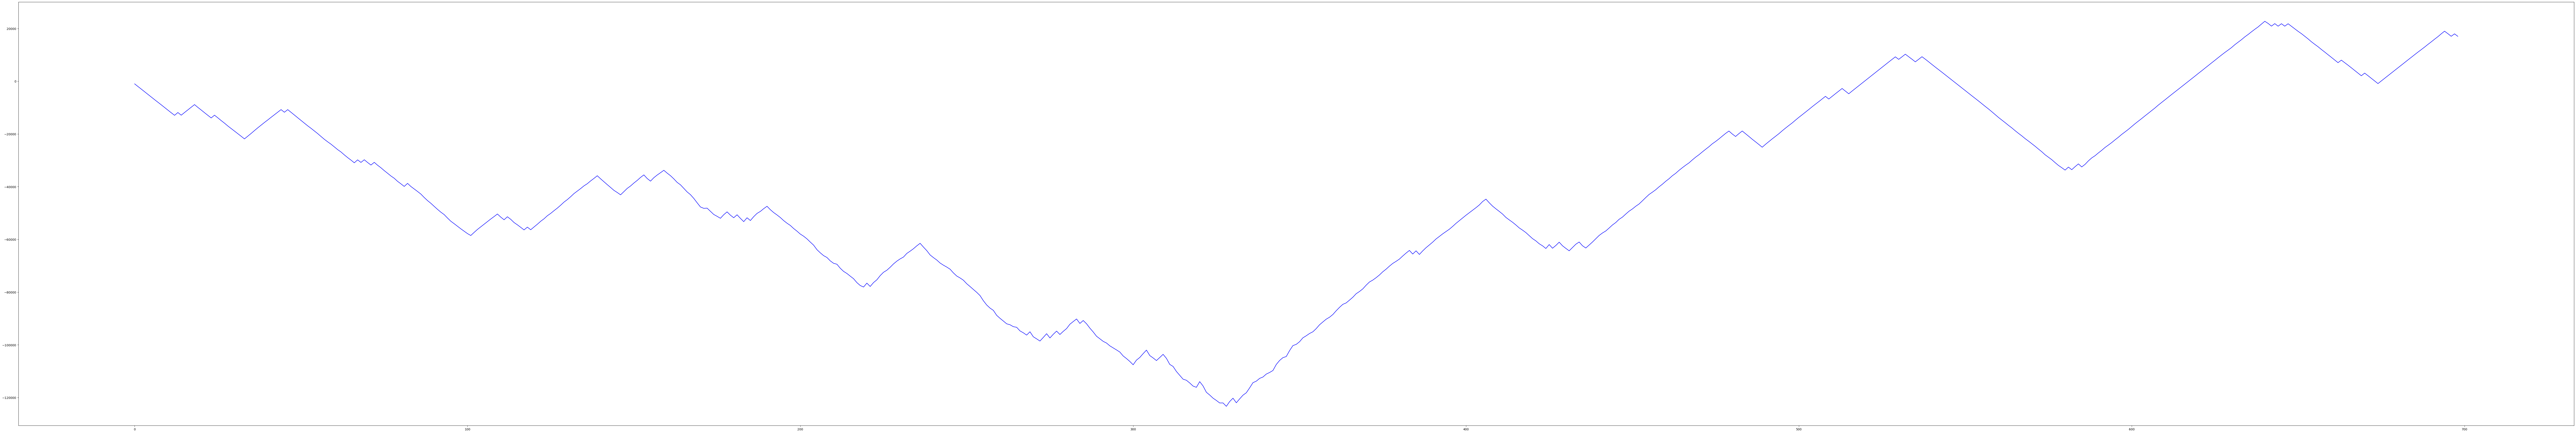

In [ ]:
plt.plot(money[:limit], c="b")



# **Tests:**